In [1]:
import torch
import torch.nn as nn

from corner import corner

from lampe.simulators import IterableSimulator
from lampe.simulators.slcp import SLCP
from lampe.nn import NRE, BCEWithLogitsLoss
from lampe.optim import AdamW
from lampe.train import SummaryWriter, Trainer, NREPipe
from lampe.mcmc import LRESampler

In [2]:
sim = SLCP().cuda()
train_loader = IterableSimulator(sim, length=256)
valid_loader = IterableSimulator(sim, length=32)

In [3]:
model = NRE(5, 8, embedding=nn.Flatten(-2), hidden_sizes=[128, 128, 128], activation='ELU')
model.train()
model.cuda()

NRE(
  (net): MLP(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (standardize): Identity()
  (embedding): Flatten(start_dim=-2, end_dim=-1)
)

In [4]:
pipe = NREPipe(model, criterion=BCEWithLogitsLoss())
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
writer = SummaryWriter(log_dir='runs/slcp/nre')  # can also log hyperparameters
trainer = Trainer(pipe, train_loader, valid_loader, optimizer, clip=1., writer=writer)

for epoch in trainer(64):
    pass  # something to do in between epochs

Epochs: 100%|████████████████████████████████████████████████| 64/64 [01:12<00:00,  1.13s/epoch, loss=0.0638, lr=0.001]


In [5]:
model.eval()
theta = torch.tensor([0.3517, -0.0883, -1.4778, 1.6406, -1.9085]).cuda()
x = sim(theta)

In [6]:
sigma = 0.05 * (sim.high - sim.low)
sampler = LRESampler(model, sim.prior, model.embedding(x), sigma=sigma)  # no_grad automatically

thetas = [t.cpu() for t in sampler(2 ** 12, burn=2 ** 10, skip=2 ** 2)]
thetas = torch.cat(thetas)

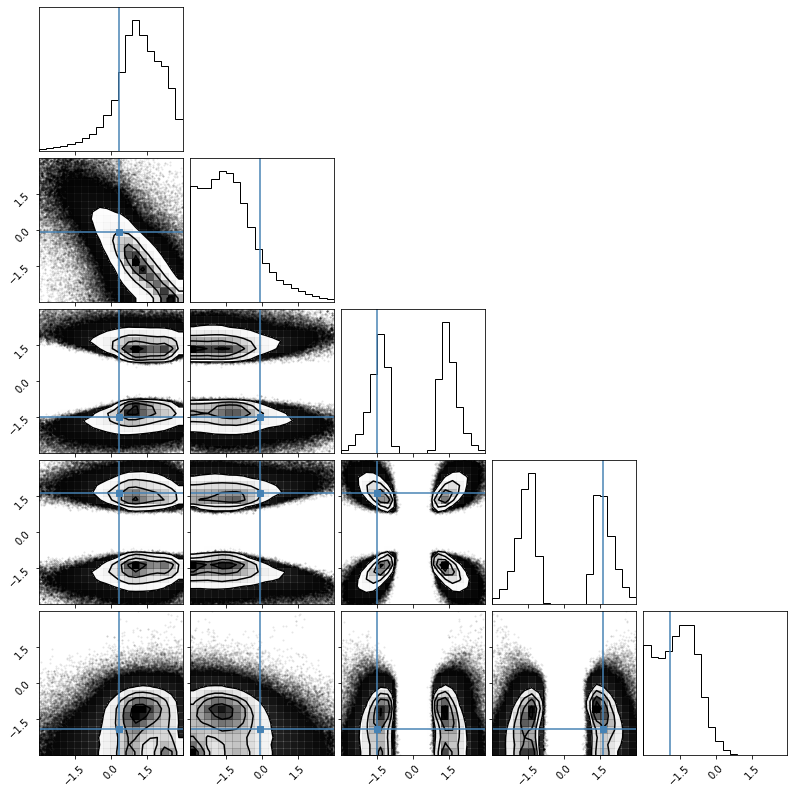

In [7]:
fig = corner(thetas.numpy(), truths=theta.cpu().numpy())